# Loading Dataset

In [1]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision.transforms import ToTensor, Compose, Grayscale, Resize, CenterCrop, Pad
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from PIL import Image
from parse import parse

#from custom_loader import AgeDBDataset, AgeDBHandler

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [3]:
class AgeDBDataset(Dataset):
    def __init__(self,
                 directory,
                 transform,
                 preload=False,
                 device: torch.device = torch.device('cpu'),
                 **kwargs):
        self.device = device
        self.directory = directory
        self.transform = transform
        self.labels = []
        self.images = []
        self.preload = preload

        for i, file in enumerate(os.listdir(self.directory)):
            file_labels = parse('{}_{}_{age}_{gender}.jpg', file)

            if file_labels is None:
                continue

            if self.preload:
                image = Image.open(os.path.join(self.directory,
                                                file)).convert('RGB')
                if self.transform is not None:
                    image = self.transform(image).to(self.device)

            else:
                image = os.path.join(self.directory, file)

            self.images.append(image)

            gender_to_class_id = {'m': 0, 'f': 1}
            gender = gender_to_class_id[file_labels['gender']]
            age = int(file_labels['age'])

            if age < 18 or age > 78:
                continue

            self.labels.append({'age': age, 'gender': gender})
        pass

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.images[idx]

        if not self.preload:
            image = Image.open(image).convert('RGB')
            if self.transform is not None:
                image = self.transform(image).to(self.device)

        labels = {
            'age': self.labels[idx]['age'],
            'gender': self.labels[idx]['gender'],
        }
        return image.to(self.device), labels

    def get_loaders(self, batch_size, train_size=0.7, test_size=0.2, **kwargs):
        train_len = int(len(self) * train_size)
        test_len = int(len(self) * test_size)
        validate_len = len(self) - (train_len + test_len)

        self.trainDataset, self.validateDataset, self.testDataset = torch.utils.data.random_split(
            dataset=self,
            lengths=[train_len, validate_len, test_len],
            generator=torch.Generator().manual_seed(42))

        train_loader = DataLoader(self.trainDataset, batch_size=batch_size)
        validate_loader = DataLoader(self.validateDataset,
                                     batch_size=batch_size)
        test_loader = DataLoader(self.testDataset, batch_size=batch_size)

        return train_loader, validate_loader, test_loader

In [4]:
dataset = AgeDBDataset(
    directory = 'AgeDB/',
    transform = Compose([
        Resize(size=(64,64)),
        CenterCrop(64),
        Grayscale(num_output_channels=1),
        ToTensor(),
    ]),
    device = device,
)

# Dataset Attributes

In [5]:
len(dataset)

15510

In [6]:
dataset[0]

(tensor([[[0.4235, 0.4275, 0.4314,  ..., 0.4078, 0.4039, 0.4000],
          [0.4235, 0.4275, 0.4353,  ..., 0.4275, 0.4196, 0.4157],
          [0.4235, 0.4275, 0.4353,  ..., 0.4510, 0.4431, 0.4392],
          ...,
          [0.6627, 0.6824, 0.6588,  ..., 0.7255, 0.7294, 0.7294],
          [0.6667, 0.6706, 0.6784,  ..., 0.7137, 0.7176, 0.7176],
          [0.6706, 0.6745, 0.6824,  ..., 0.6980, 0.6980, 0.6980]]],
        device='cuda:0'),
 {'age': 35, 'gender': 1})

In [7]:
type(dataset[0])

tuple

In [8]:
dataset.labels[0]

{'age': 35, 'gender': 1}

In [9]:
print(dataset.images[48])

AgeDB/10043_HelenHunt_30_f.jpg


249 248
400 400


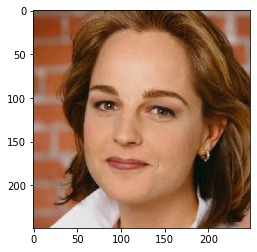

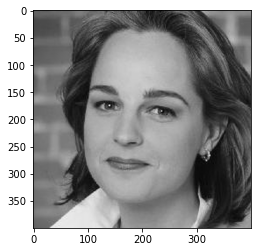

In [10]:
plt.figure()
image = Image.open(dataset.images[48])
plt.imshow((image))
print(image.height, image.width)
image = image.resize(
    size = (400,400),
    resample=Image.LANCZOS,
)
plt.figure()
image = image.convert('LA')
plt.imshow(image)
print(image.height, image.width)

In [11]:
age = []
gender = []
for i in range(len(dataset)):
    age.append(dataset.labels[i]['age'])
    gender.append(dataset.labels[i]['gender'])

In [12]:
print("Highest Age Value: "+str(max(age))+"\nLowest Age Value: "+str(min(age)))

Highest Age Value: 78
Lowest Age Value: 18


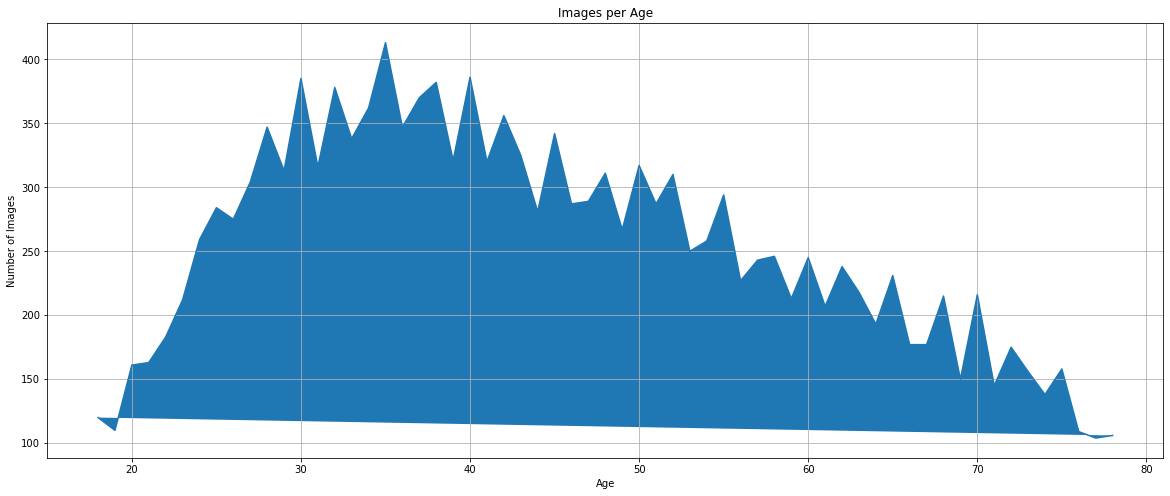

In [13]:
listofzeros = [0] * len(dataset)
same_age = [i for i in range(min(age), max(age) + 1)]
age_number = dict(zip(same_age, listofzeros))

for i in range(len(dataset)):
    if age[i] in age_number:
        age_number[age[i]] += 1

age_amount = age_number.items()
x, y = zip(*age_amount)

plt.figure(figsize = (20, 8))
plt.plot(x, y)
plt.fill(x, y)
plt.title("Images per Age")
plt.xlabel("Age")
plt.ylabel("Number of Images")
plt.grid()
plt.show()

In [14]:
age_number

{18: 120,
 19: 110,
 20: 161,
 21: 163,
 22: 183,
 23: 212,
 24: 259,
 25: 284,
 26: 275,
 27: 304,
 28: 347,
 29: 313,
 30: 385,
 31: 316,
 32: 378,
 33: 338,
 34: 362,
 35: 413,
 36: 347,
 37: 370,
 38: 382,
 39: 321,
 40: 386,
 41: 320,
 42: 356,
 43: 325,
 44: 281,
 45: 342,
 46: 287,
 47: 289,
 48: 311,
 49: 267,
 50: 317,
 51: 287,
 52: 310,
 53: 250,
 54: 258,
 55: 294,
 56: 227,
 57: 243,
 58: 246,
 59: 213,
 60: 245,
 61: 207,
 62: 238,
 63: 218,
 64: 193,
 65: 231,
 66: 177,
 67: 177,
 68: 215,
 69: 150,
 70: 216,
 71: 145,
 72: 175,
 73: 156,
 74: 138,
 75: 158,
 76: 109,
 77: 104,
 78: 106}

# Split Dataset

In [15]:
# hyper params
input_size = 64*64
num_of_class = 102
hidden_unit = 256
learning_rate = 0.01
batch_size = 64

In [16]:
train_set, validation_set, test_set = dataset.get_loaders(
    batch_size=batch_size,
    train_size=0.8,
    test_size=0.2,
)

In [17]:
len(train_set), len(validation_set), len(test_set)

(194, 0, 49)

In [18]:
def findAge(t_loader):
    listofzeros = [0] * len(dataset)
    same_age = [i for i in range(min(age), max(age) + 1)]
    age_number = dict(zip(same_age, listofzeros))
    sum = 0

    for i, (imgs, labels) in enumerate(t_loader):

        X_train_images = imgs.to(device)
        y_train_ages = labels['age'].to(device)

        for i in range(len(y_train_ages)):
            if y_train_ages[i].item() in age_number:
                age_number[y_train_ages[i].item()] += 1
                sum += 1
    return age_number

In [19]:
def plotTTage(train, test):
    #plot 1:
    train_age = findAge(train).items()
    x1, y1 = zip(*train_age)

    #plot 2:
    test_age = findAge(test).items()
    x2, y2 = zip(*test_age)

    plt.figure(figsize = (20, 8))
    plt.plot(x1, y1)
    plt.plot(x2, y2)

    plt.legend(["Train", "Test"], prop={'size': 16})

    plt.title("Data Distribution")
    plt.xlabel("Age")
    plt.ylabel("Number of Images")

    plt.grid()

    plt.show()

In [20]:
train_age_distribution, test_age_distribution = findAge(train_set), findAge(test_set)

In [21]:
keys = train_age_distribution.keys()
temp = zip(train_age_distribution.values(), test_age_distribution.values())
sample_per_age = dict(zip(keys, temp))
print('Age: (Sample in Train, Sample in Test)')
sample_per_age

Age: (Sample in Train, Sample in Test)


{18: (97, 23),
 19: (86, 24),
 20: (139, 22),
 21: (132, 31),
 22: (149, 34),
 23: (166, 46),
 24: (213, 46),
 25: (218, 66),
 26: (223, 52),
 27: (251, 53),
 28: (289, 58),
 29: (254, 59),
 30: (309, 76),
 31: (250, 66),
 32: (301, 77),
 33: (273, 65),
 34: (290, 72),
 35: (328, 85),
 36: (288, 59),
 37: (302, 68),
 38: (299, 83),
 39: (262, 59),
 40: (303, 83),
 41: (248, 72),
 42: (287, 69),
 43: (243, 82),
 44: (219, 62),
 45: (260, 82),
 46: (235, 52),
 47: (228, 61),
 48: (252, 59),
 49: (221, 46),
 50: (256, 61),
 51: (229, 58),
 52: (248, 62),
 53: (194, 56),
 54: (210, 48),
 55: (244, 50),
 56: (176, 51),
 57: (198, 45),
 58: (191, 55),
 59: (172, 41),
 60: (194, 51),
 61: (176, 31),
 62: (187, 51),
 63: (172, 46),
 64: (153, 40),
 65: (181, 50),
 66: (137, 40),
 67: (144, 33),
 68: (168, 47),
 69: (122, 28),
 70: (172, 44),
 71: (117, 28),
 72: (135, 40),
 73: (121, 35),
 74: (105, 33),
 75: (131, 27),
 76: (87, 22),
 77: (84, 20),
 78: (89, 17)}

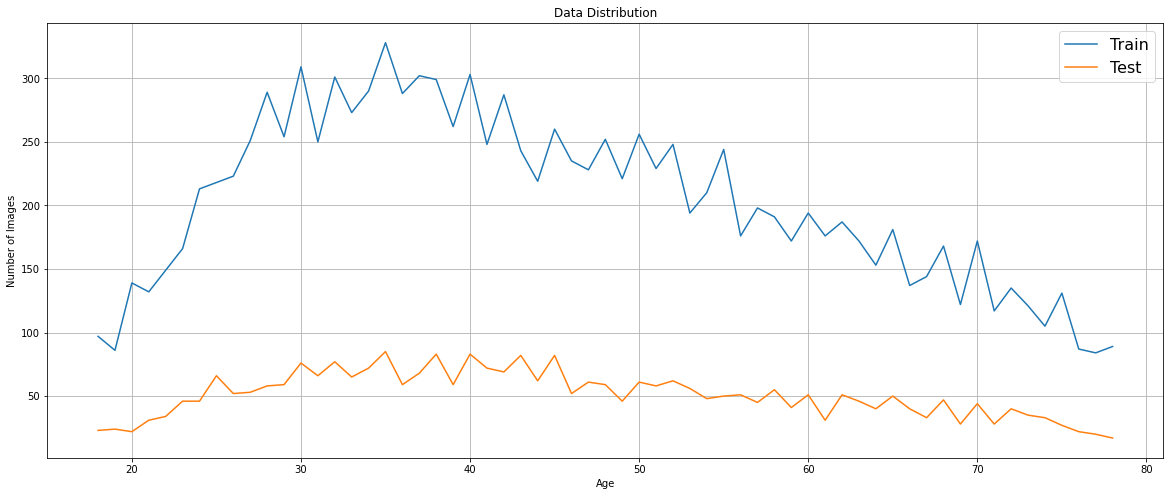

In [22]:
plotTTage(train_set, test_set)

In [23]:
img, lbl = iter(train_set).next()

In [24]:
img.shape, lbl['age'].shape

(torch.Size([64, 1, 64, 64]), torch.Size([64]))

# Train Model and Evaluate

In [25]:
# define the model
class AGEDBModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_of_class):
        super(AGEDBModel, self).__init__()
        self.input = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_size, num_of_class)
        
    def forward(self, x):
        out = self.input(x)
        out = self.relu(out)
        out = self.output(out)
        out = out.reshape(out.size(0), -1) #add
        return out

In [26]:
model = AGEDBModel(
    input_size=input_size,
    hidden_size=hidden_unit,
    num_of_class=num_of_class,
).to(device)

In [27]:
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [28]:
#write the training loop
def train(model, optimizer, criterion, train_loader, num_of_epoch):
    total_step = len(train_loader)
    model.train()
    for epoch in range(num_of_epoch):
        
        for i, (imgs, labels) in enumerate(train_loader):
            imgs = imgs.reshape(-1, 64*64).to(device)
            labels = torch.as_tensor(labels['age']).to(device)
            
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1)%total_step == 0:
                print(f"Epoch: {epoch+1}/{num_of_epoch}, Step: {i+1}/{total_step}, Loss: {loss.item()}")

In [29]:
train(model, optimizer, criteria, train_set, num_of_epoch=10)

Epoch: 1/10, Step: 194/194, Loss: 4.079610347747803
Epoch: 2/10, Step: 194/194, Loss: 4.046677589416504
Epoch: 3/10, Step: 194/194, Loss: 4.042065620422363
Epoch: 4/10, Step: 194/194, Loss: 4.027268409729004
Epoch: 5/10, Step: 194/194, Loss: 4.032249927520752
Epoch: 6/10, Step: 194/194, Loss: 4.071491718292236
Epoch: 7/10, Step: 194/194, Loss: 4.0165486335754395
Epoch: 8/10, Step: 194/194, Loss: 4.011968612670898
Epoch: 9/10, Step: 194/194, Loss: 4.010354042053223
Epoch: 10/10, Step: 194/194, Loss: 4.009387493133545


In [30]:
def eval(model, test_loader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for imgs, labels in test_loader:
            imgs = imgs.reshape(-1,64*64).to(device)
            labels = torch.as_tensor(labels['age']).to(device)
            outputs = model(imgs)
            
            _, pred = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (pred == labels).sum().item()
            
    print(f"ACC: {(100*correct)/total}%")
    print("C: ", correct, " T:", total)

In [31]:
eval(model, test_set)

ACC: 2.740167633784655%
C:  85  T: 3102


In [32]:
eval(model, train_set)

ACC: 2.6434558349451964%
C:  328  T: 12408
